
🚀 Running Backtest for RISK_AVERSE Portfolio...



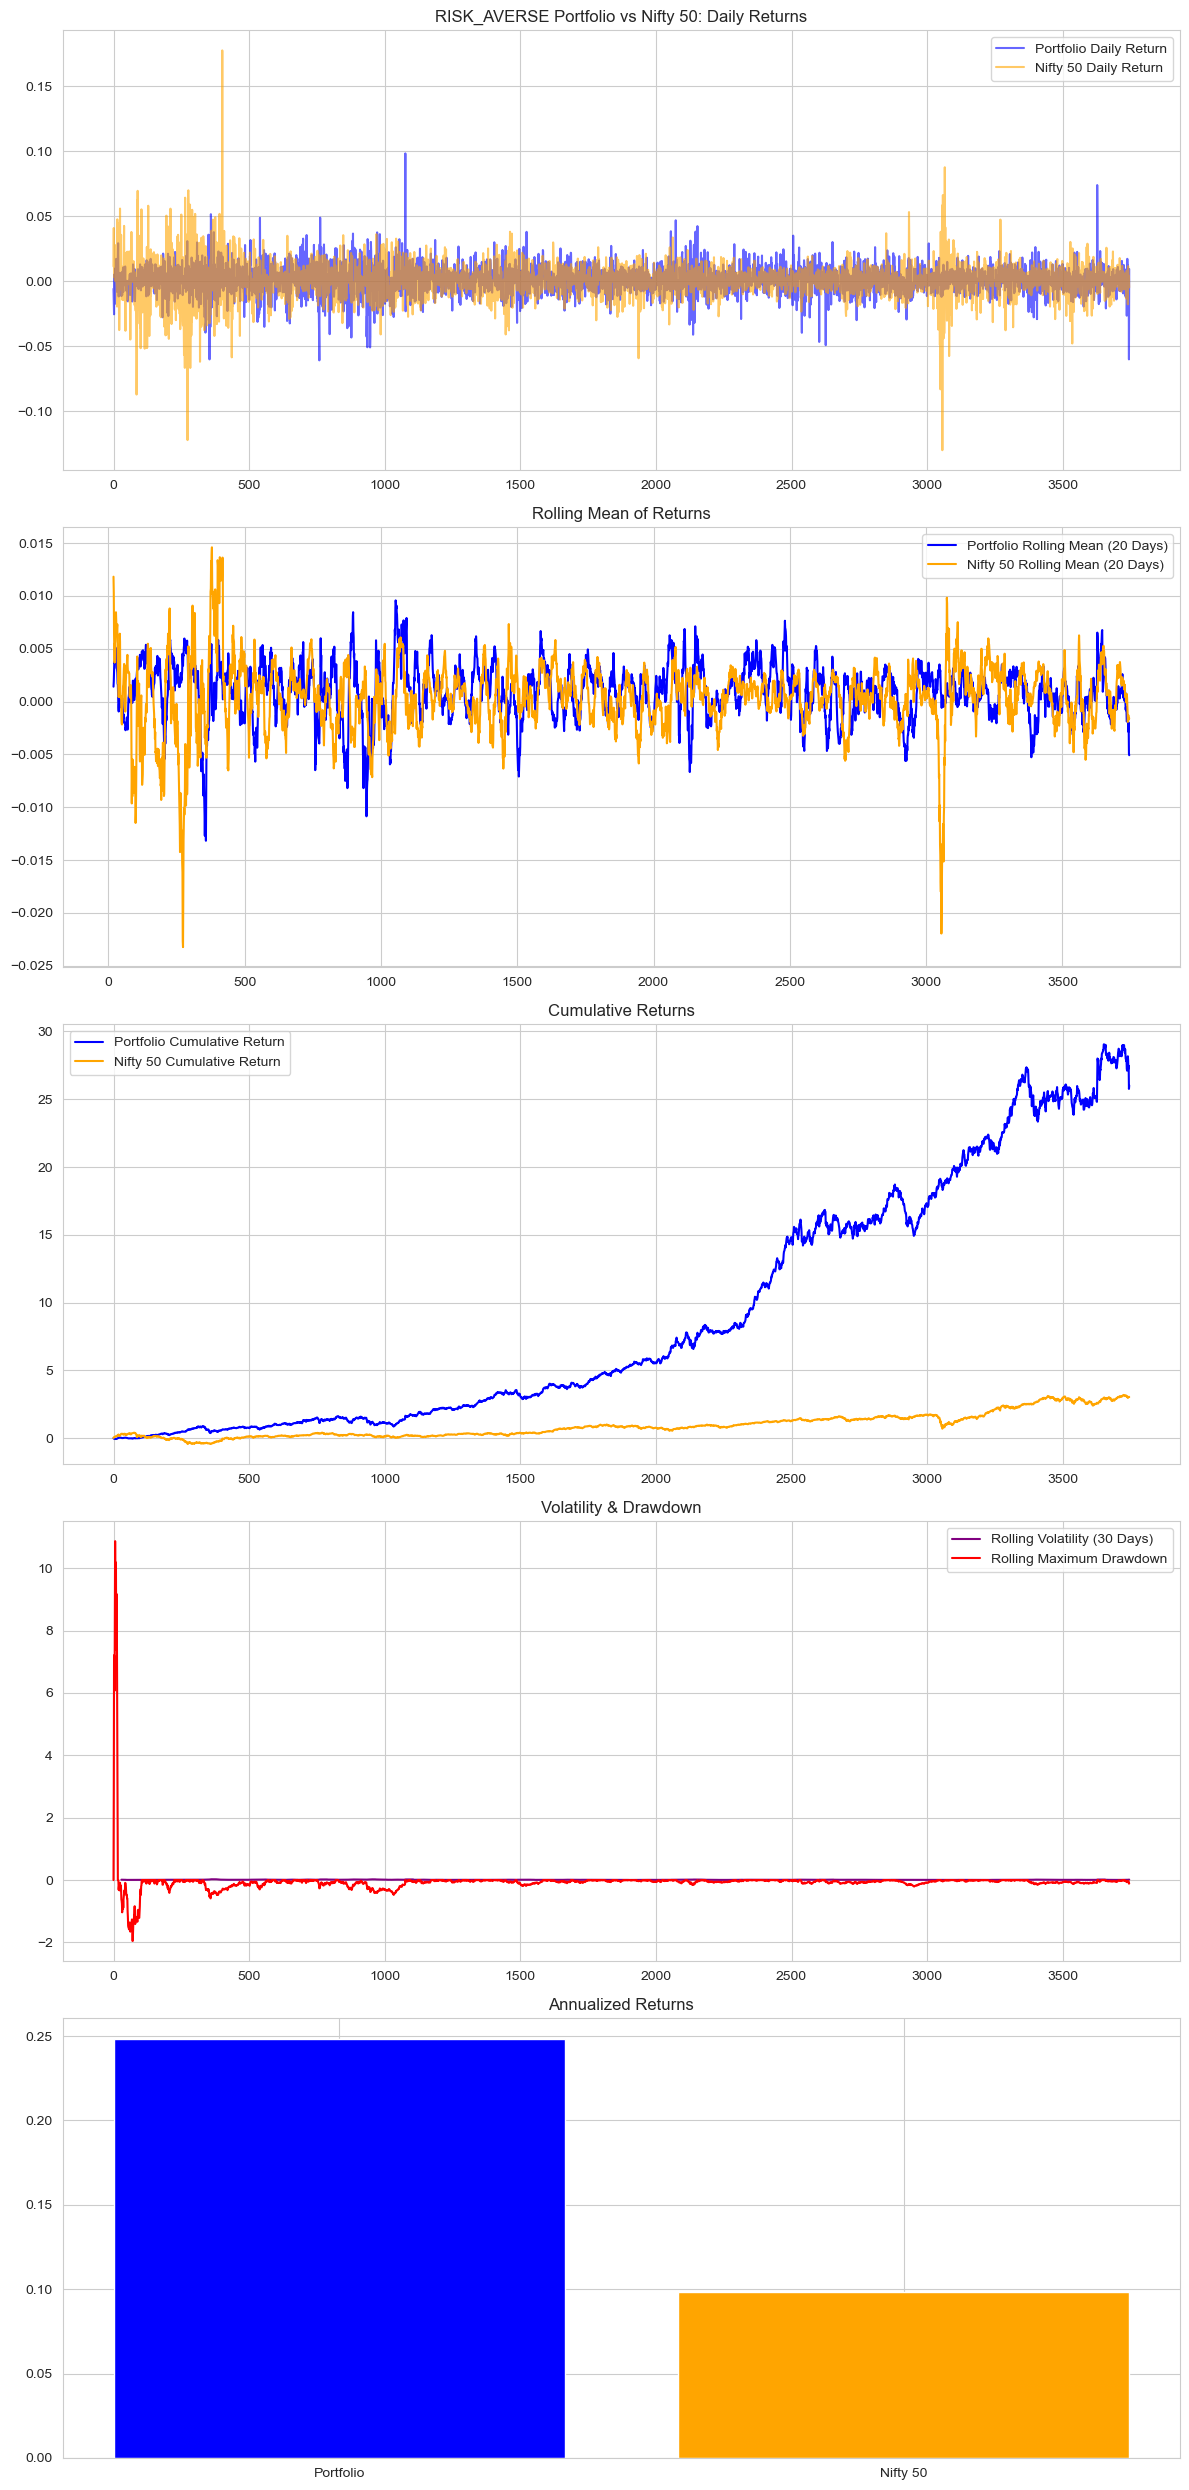

📊 RISK_AVERSE Portfolio - Annualized Sharpe Ratio: 1.1444
📈 RISK_AVERSE Portfolio - Annualized Return: 0.2483
📉 Nifty 50 - Annualized Return: 0.0983

🚀 Running Backtest for RISK_NEUTRAL Portfolio...



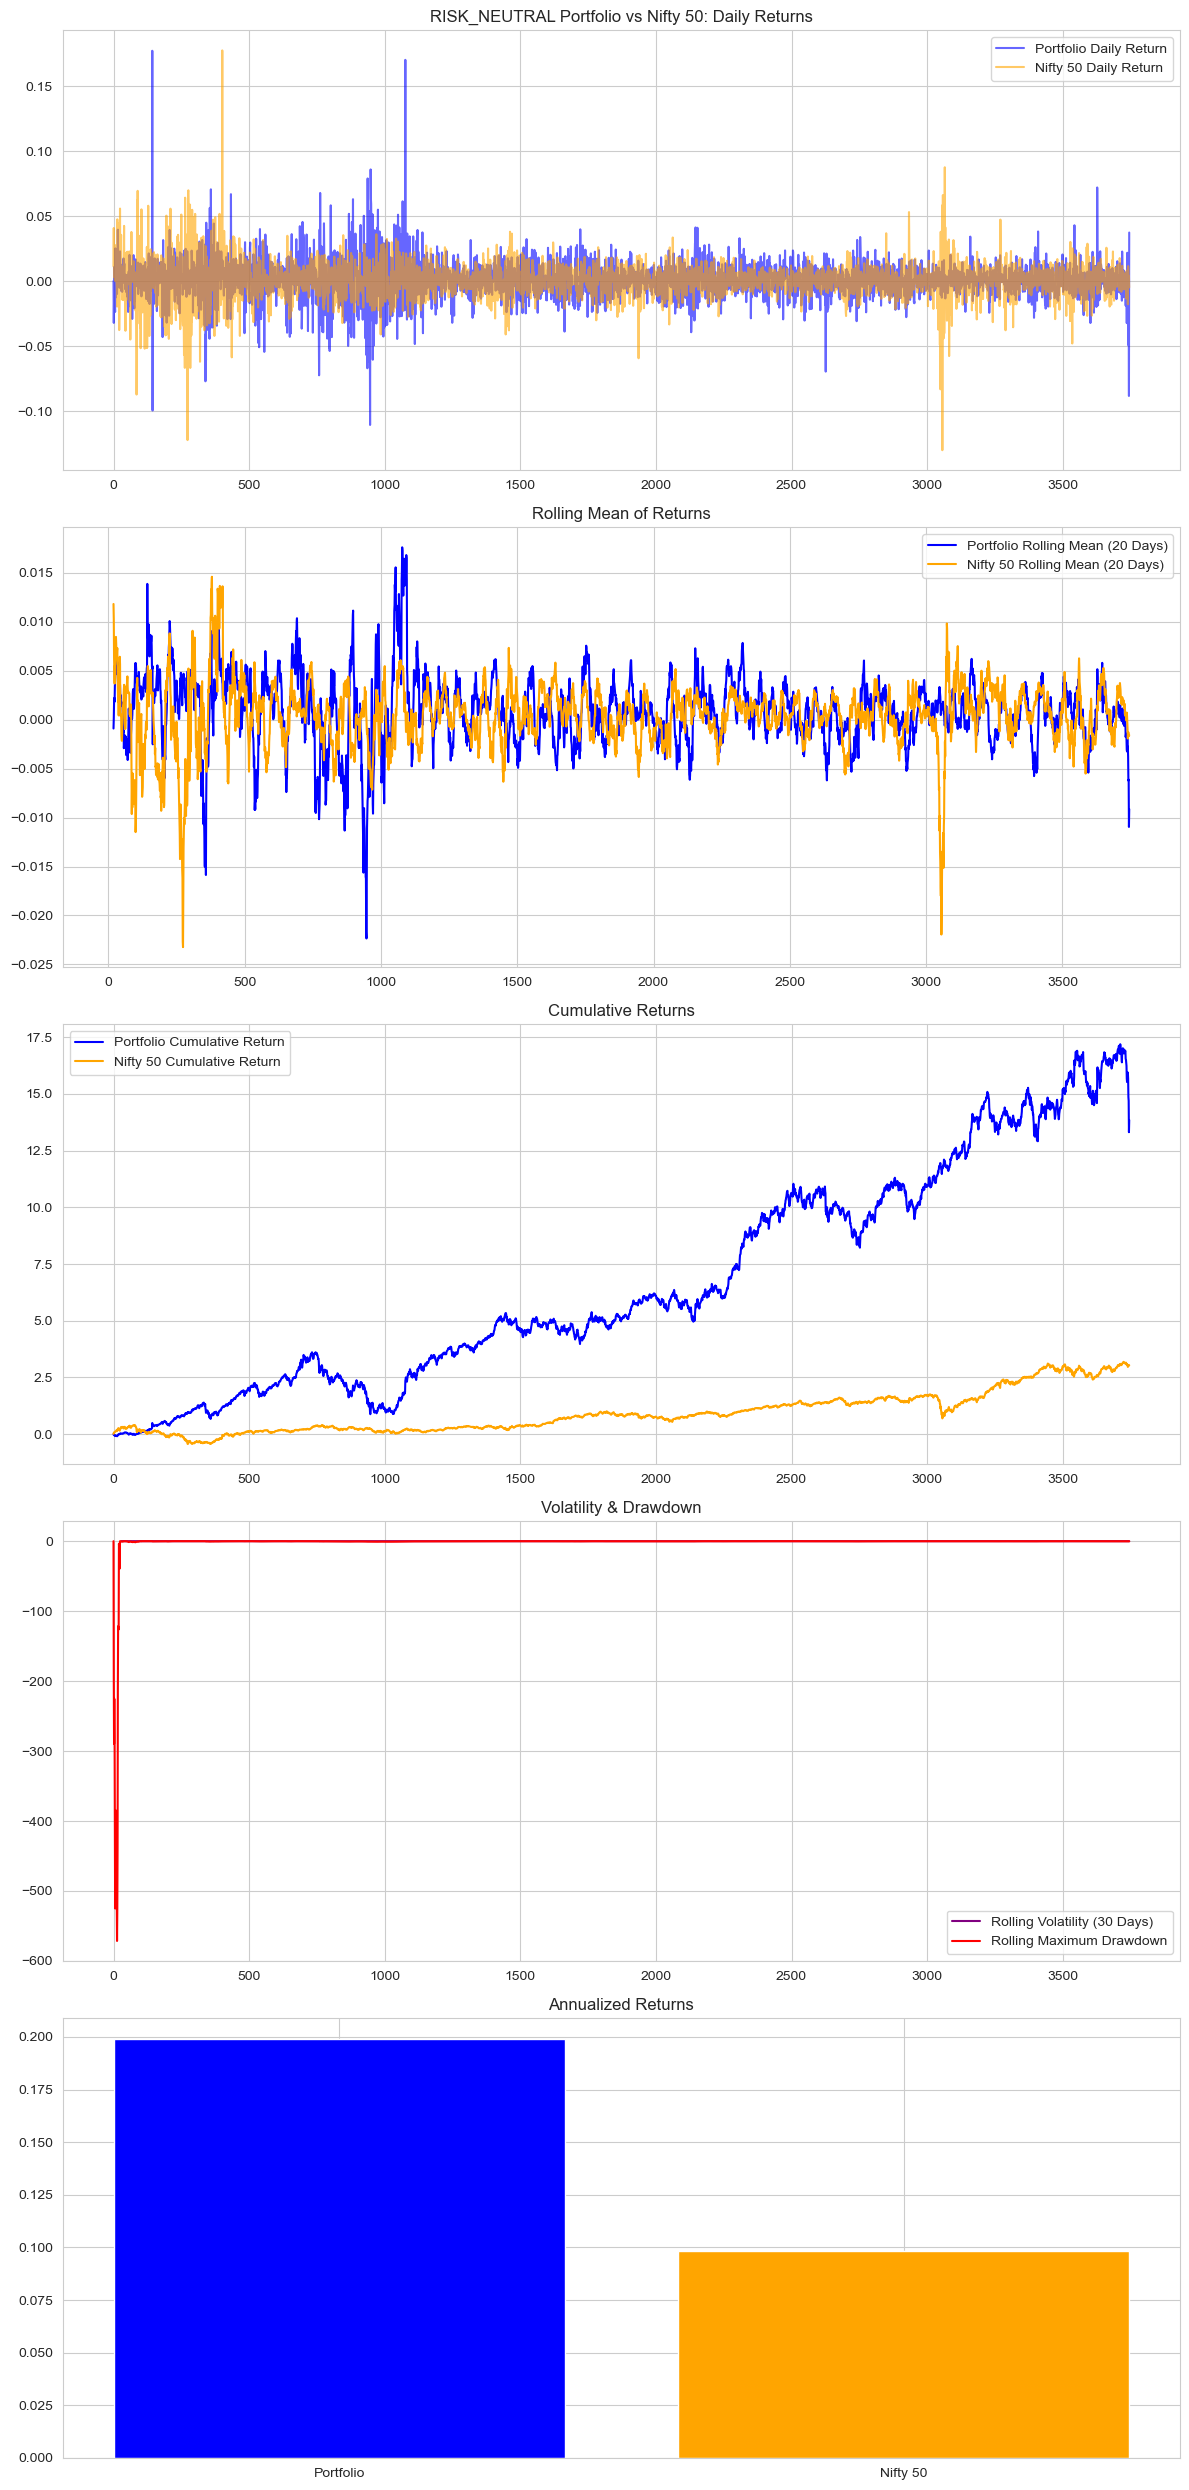

📊 RISK_NEUTRAL Portfolio - Annualized Sharpe Ratio: 0.7216
📈 RISK_NEUTRAL Portfolio - Annualized Return: 0.1990
📉 Nifty 50 - Annualized Return: 0.0983

🚀 Running Backtest for RISK_SEEKING Portfolio...



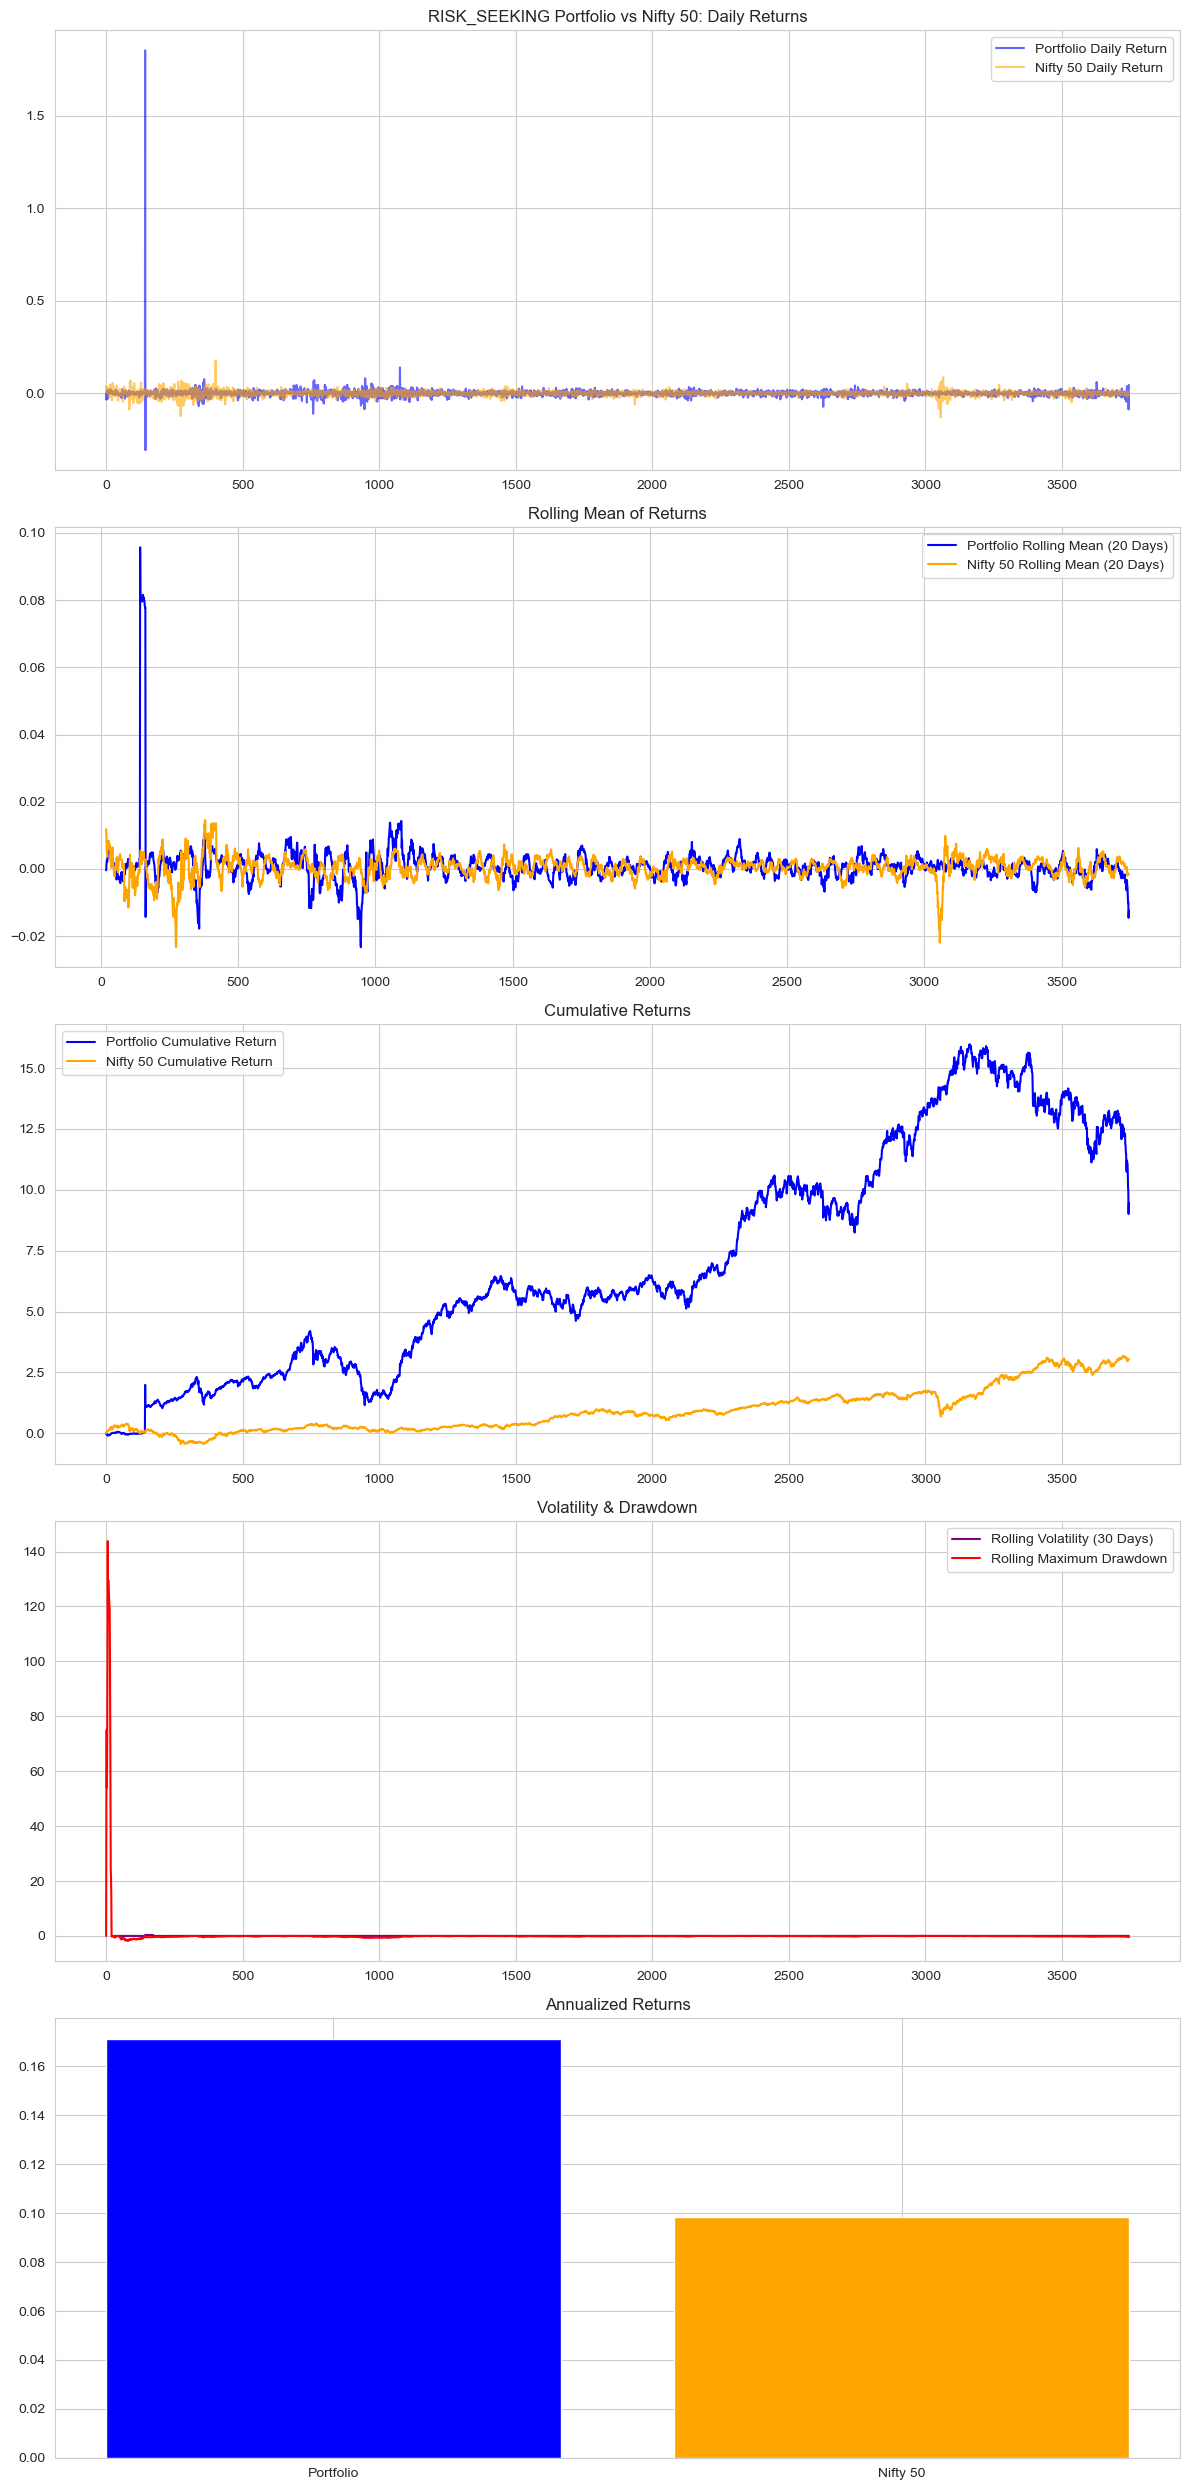

📊 RISK_SEEKING Portfolio - Annualized Sharpe Ratio: 0.3741
📈 RISK_SEEKING Portfolio - Annualized Return: 0.1712
📉 Nifty 50 - Annualized Return: 0.0983


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

def backtest_portfolio_with_benchmark(data_folder, portfolio_weights_file, nifty_data_file, category, feature_column='Close', transaction_cost=0.01, rolling_window=20, risk_free_rate=0.04, extreme_threshold=1000):
    print(f"\n🚀 Running Backtest for {category.upper()} Portfolio...\n")

    # Gather relevant stock files based on category
    categorized_results_folder = "/Users/pranayvij/MTP-Work/categorized_results/"
    category_file = os.path.join(categorized_results_folder, f"{category}_stocks.csv")
    
    if not os.path.exists(category_file):
        print(f"⚠️ No categorized stock list found for {category}. Skipping...")
        return

    category_df = pd.read_csv(category_file)
    tickers = category_df['Ticker'].tolist()
    
    # Load corresponding stock files for this portfolio category
    stock_data_files = [os.path.join(data_folder, f"{ticker}.csv") for ticker in tickers if os.path.exists(os.path.join(data_folder, f"{ticker}.csv"))]

    if not stock_data_files:
        print(f"⚠️ No stock data found for {category}. Skipping...")
        return

    # Load portfolio weights
    portfolio_weights = pd.read_csv(portfolio_weights_file, header=None)

    # Ensure weights match available stock data
    if portfolio_weights.shape[1] != len(stock_data_files):
        print(f"⚠️ Mismatch: Portfolio weights ({portfolio_weights.shape[1]} stocks) vs available data ({len(stock_data_files)}). Skipping...")
        return

    # Read stock returns
    stock_returns_list = []
    for file in stock_data_files:
        stock_data = pd.read_csv(file)
        stock_returns = stock_data[feature_column].pct_change().dropna()
        stock_returns_list.append(stock_returns.values)

    # Load Nifty 50 data and calculate returns
    nifty_data = pd.read_csv(nifty_data_file)
    nifty_returns = nifty_data[feature_column].pct_change().dropna().values

    # Ensure all time series have the same length
    min_length = min(len(r) for r in stock_returns_list + [portfolio_weights, nifty_returns])
    stock_returns = np.array([r[:min_length] for r in stock_returns_list]).T
    portfolio_weights = portfolio_weights.values[:min_length, :]
    nifty_returns = nifty_returns[:min_length]

    # Identify and remove extreme weight allocations
    extreme_rows = (np.abs(portfolio_weights) > extreme_threshold).any(axis=1)
    filtered_weights = portfolio_weights[~extreme_rows]
    filtered_returns = stock_returns[~extreme_rows]
    filtered_nifty_returns = nifty_returns[~extreme_rows]

    # Normalize portfolio weights to sum to 1
    filtered_weights = filtered_weights / np.clip(filtered_weights.sum(axis=1, keepdims=True), 1e-6, None)
    portfolio_returns = np.sum(filtered_returns * filtered_weights, axis=1)

    # Apply transaction costs
    for i in range(1, len(portfolio_returns)):
        rebalance_cost = transaction_cost * np.sum(np.abs(filtered_weights[i] - filtered_weights[i-1]))
        portfolio_returns[i] -= rebalance_cost

    # Compute cumulative returns
    portfolio_cumulative_returns = np.cumprod(1 + portfolio_returns) - 1
    nifty_cumulative_returns = np.cumprod(1 + filtered_nifty_returns) - 1

    # Rolling statistics and risk metrics
    rolling_portfolio_returns = pd.Series(portfolio_returns).rolling(window=rolling_window).mean()
    rolling_nifty_returns = pd.Series(filtered_nifty_returns).rolling(window=rolling_window).mean()
    sharpe_ratio = (np.mean(portfolio_returns) * 252 - risk_free_rate) / (np.std(portfolio_returns) * np.sqrt(252))

    rolling_volatility = pd.Series(portfolio_returns).rolling(window=30).std()
    rolling_max = np.maximum.accumulate(portfolio_cumulative_returns)
    rolling_drawdown = (portfolio_cumulative_returns - rolling_max) / rolling_max

    portfolio_annualized_return = np.prod(1 + portfolio_returns) ** (252 / len(portfolio_returns)) - 1
    nifty_annualized_return = np.prod(1 + filtered_nifty_returns) ** (252 / len(filtered_nifty_returns)) - 1

    # Visualization
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(5, 1, figsize=(12, 25))

    ax[0].plot(portfolio_returns, label="Portfolio Daily Return", color='blue', alpha=0.6)
    ax[0].plot(filtered_nifty_returns, label="Nifty 50 Daily Return", color='orange', alpha=0.6)
    ax[0].set_title(f"{category.upper()} Portfolio vs Nifty 50: Daily Returns")
    ax[0].legend()
    
    ax[1].plot(rolling_portfolio_returns, label=f"Portfolio Rolling Mean ({rolling_window} Days)", color='blue')
    ax[1].plot(rolling_nifty_returns, label=f"Nifty 50 Rolling Mean ({rolling_window} Days)", color='orange')
    ax[1].set_title("Rolling Mean of Returns")
    ax[1].legend()
    
    ax[2].plot(portfolio_cumulative_returns, label="Portfolio Cumulative Return", color='blue')
    ax[2].plot(nifty_cumulative_returns, label="Nifty 50 Cumulative Return", color='orange')
    ax[2].set_title("Cumulative Returns")
    ax[2].legend()

    ax[3].plot(rolling_volatility, label="Rolling Volatility (30 Days)", color='purple')
    ax[3].plot(rolling_drawdown, label="Rolling Maximum Drawdown", color='red')
    ax[3].set_title("Volatility & Drawdown")
    ax[3].legend()

    ax[4].bar(["Portfolio", "Nifty 50"], [portfolio_annualized_return, nifty_annualized_return], color=['blue', 'orange'])
    ax[4].set_title("Annualized Returns")
    
    plt.tight_layout()
    plt.show()
    
    # Print key metrics
    print(f"📊 {category.upper()} Portfolio - Annualized Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"📈 {category.upper()} Portfolio - Annualized Return: {portfolio_annualized_return:.4f}")
    print(f"📉 Nifty 50 - Annualized Return: {nifty_annualized_return:.4f}")

    return portfolio_cumulative_returns, nifty_cumulative_returns


# File paths for backtesting
data_folder = "/Users/pranayvij/MTP-Work/data"
nifty_data_file = "/Users/pranayvij/MTP-Work/^NSEI.csv"
result_folder = "/Users/pranayvij/MTP-Work/results"

# Portfolio categories
portfolio_categories = ["risk_averse", "risk_neutral", "risk_seeking"]

for category in portfolio_categories:
    portfolio_weights_file = os.path.join(result_folder, f"portfolio_weights_{category}.csv")

    if not os.path.exists(portfolio_weights_file):
        print(f"⚠️ Portfolio weights file missing for {category}. Skipping...")
        continue

    backtest_portfolio_with_benchmark(
        data_folder,
        portfolio_weights_file,
        nifty_data_file,
        category=category,
        transaction_cost=0.01
    )
